In [2]:
# %load std_ipython_import.txt
import pandas as pd
import scipy as spy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.mixture import GMM

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
pd.set_option('expand_frame_repr', True)

%matplotlib inline
%config InlineBackend.figure_formats = {'retina',}

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [3]:
data = pd.read_csv('SAheart.data', sep=',', decimal='.', usecols=np.arange(1,11))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462 entries, 0 to 461
Data columns (total 10 columns):
sbp          462 non-null int64
tobacco      462 non-null float64
ldl          462 non-null float64
adiposity    462 non-null float64
famhist      462 non-null object
typea        462 non-null int64
obesity      462 non-null float64
alcohol      462 non-null float64
age          462 non-null int64
chd          462 non-null int64
dtypes: float64(5), int64(4), object(1)
memory usage: 37.9+ KB


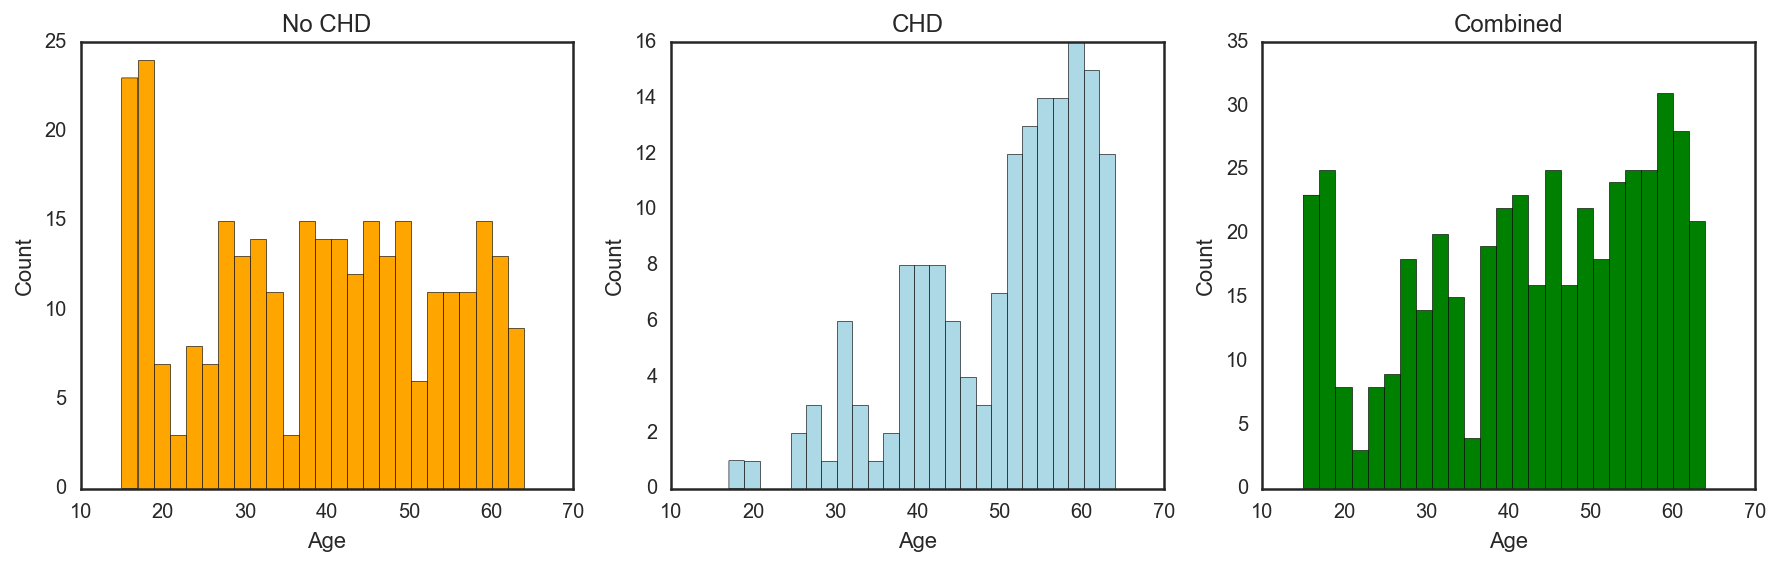

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

ax1.hist(data[data.chd == 0]['age'].values, bins=25, color='orange');
ax1.set_title('No CHD')

ax2.hist(data[data.chd == 1]['age'].values, bins=25, color='lightblue');
ax2.set_title('CHD')

ax3.hist(data.age.values, bins=25, color='g');
ax3.set_title('Combined')

for ax in fig.axes:
    ax.set_xlabel('Age')
    ax.set_ylabel('Count')

In [51]:
mixm = GMM(n_components=2, covariance_type='diag', verbose=True)

mixm.fit(data[['age']])

Expectation-maximization algorithm started.
Initialization 1
	EM iteration 1
	EM iteration 2
	EM iteration 3
	EM iteration 4
	EM iteration 5
	EM iteration 6
	EM iteration 7
	EM iteration 8
		EM algorithm converged.


GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=True)

In [49]:
mixm.means_

array([[ 42.81601732]])

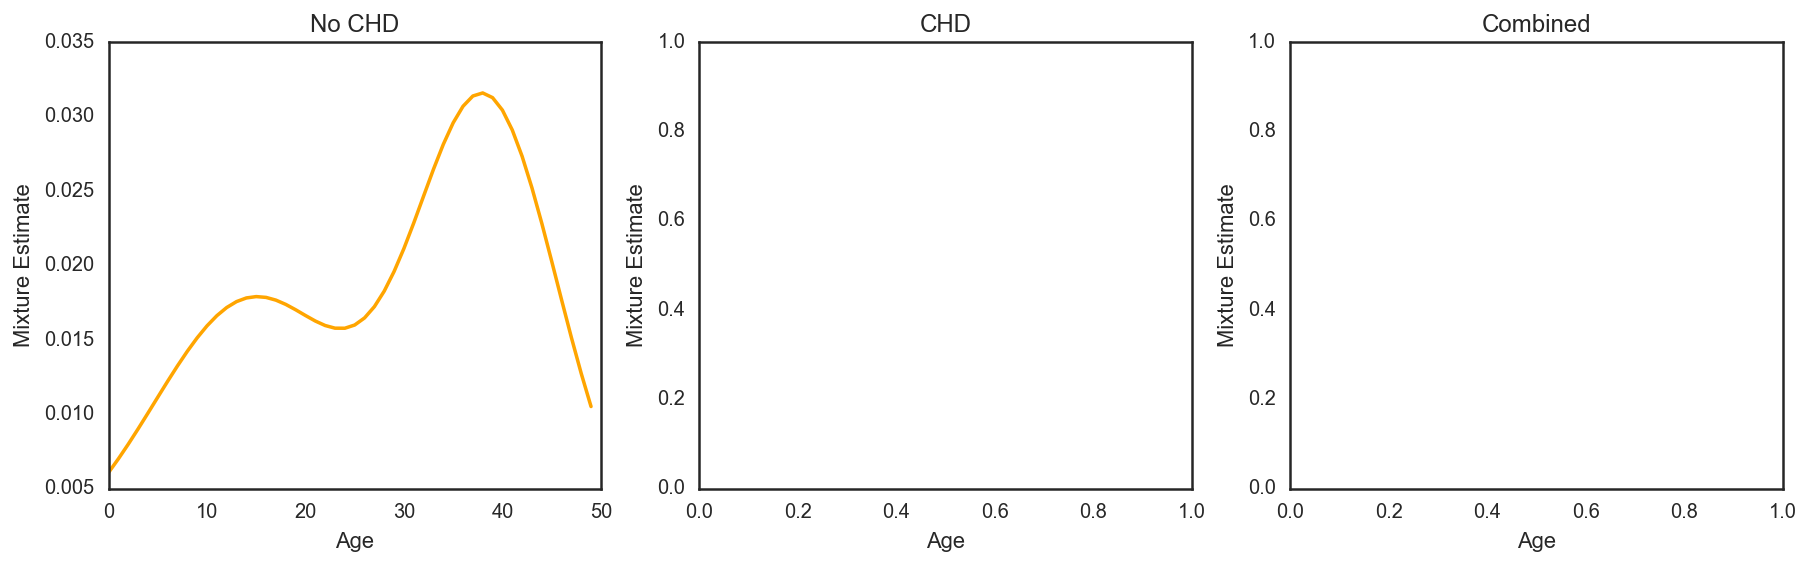

In [52]:
x = np.linspace(data.age.min(), data.age.max())
y0 = np.zeros_like(x)
y1 = np.ones_like(x)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

ax1.plot(np.exp(mixm.score_samples(x.reshape(-1,1))[0]), c='orange')
#ax1.plot(np.exp(mixm.score_samples(np.c_[x,y0])[0]), c='orange')
ax1.set_title('No CHD')

#ax2.plot(np.exp(mixm.score_samples(np.c_[x,y1])[0]), c='lightblue')
ax2.set_title('CHD')

#ax2.plot(np.exp(mixm.score_samples(np.c_[x,y1])[0]), c='lightblue')
ax3.set_title('Combined')

for ax in fig.axes:
    ax.set_xlabel('Age')
    ax.set_ylabel('Mixture Estimate')